# STA 208: Homework 1 (Do not distribute)

## Due 4/10/19 midnight 

__Instructions:__ To make grading easier for the TAs please submit it on canvas in a zip file with either the scanned solutions clearly written or in the jupyter notebook below.  The zip file should include all of your code either in this notebook file, or a separate python file that is imported and ran in this notebook.  We should be able to open this notebook and run everything here by running the cells in sequence.  The written portions can be either done in markdown and TeX in new cells or written clearly by hand and scanned.

- Code should be well organized and documented
- All math should be clear and make sense sequentially
- When in doubt explain what is going on
- You will be graded on correctness of your math, code efficiency and succinctness, and conclusions and modelling decisions

__Exercise 1__ (20 pts)

Consider the binary classification setting where the training data is $x_i \in \mathbb R^p, y_i \in \{0,1\}, i=1,\ldots,n$ and recall the empirical risk (as a function of the predictor $g : \mathbb R^p \to \{0,1\}$),
$$
R_n(g) = \frac 1n \sum_{i=1}^n \ell(y_i, g(x_i)),
$$
and the true risk is 
$$
R(g) = \mathbb E \ell(Y,g(X))
$$
where $X,Y$ are drawn from their joint distribution $f_{X,Y}(x,y)$.

1. Suppose that the loss function is the Hamming loss, $\ell(y,\hat y) = 1\{ y \ne \hat y\}$.  What is the predictor that minimizes the True risk?  (Hint: derive an expression for this based on the joint distribution - you can use expressions involving conditional probabilities.)  This predictor is called the Bayes rule.
2. Suppose that we know that the Bayes rule can be written in the form, 
$$
h_j(x) = 1\{ x_j > 0 \}, 
$$
for some $j = 1,\ldots,p$, but we don't know which one.  Now using the empirical risk, what is a reasonable classification algorithm (Hint: you can think of finding a good classifier as a problem of finding $j$).  Describe the fit and predict methods. 
3. (Challenging) Suppose that I told you that for any fixed $j$ the following probability bound holds (from Hoeffding's inequality)
$$
\mathbb P \left\{ |R_n(h_j) - R(h_j)| > t \right\} \le 2 \exp \left( - 2 n t^2 \right).
$$
If $p=10$, how many samples would I need to get a classifier $\hat g$, from the previous question (part 2), such that 
$$
\mathbb P \left\{ R(\hat g) < R(h) + 0.1 \right\} \ge 0.95.
$$
where $h$ is the Bayes rule, namely, the $h_j$ that minimizes $R$.
(Hint: use the union bound to show that $R_n(\hat g) \approx R(\hat g)$ and use the fact that $R_n(\hat g) \le R_n(h_j)$ for any $j$ because it is in the minimizer.)

__Exercise 2__ (20 pts)

Consider the regression setting in which $x_i \in \mathbb R^p$ and $y_i \in \mathbb R$, for $i=1,\ldots,n$ and $p < n$.

1. For a given regressor, let $\hat y_i$ be prediction given $x_i$, and $\hat y$ be the vector form.  Show that both linear regression and k-nearest neighbors can be written in the form
$$
\hat y = H y,
$$
where $H$ is dependent on $X$ (the matrix of where each row is $x_i$), assuming that $p < n$ and $X$ is full rank.  Give an expression for $H$ or an algorithm for computing $H$.  Assume that the KNN algorithm will use the same point as its own nearest neighbor (this is consistent with what you get if you use the same dataset in fit and predict in sklearn.)  You can just write it in words or pseudocode. 
2. Give a simple modification to your algorithm to compute the KNN's $H$ matrix so that a sample does not use its own point.  Derive an expression for the leave-one-out cross validated squared error based on this $H$. You can just write it in words or pseudocode. 
3. For linear regression (with $p < n$ and $X$ is full rank), let $X = U D V^\top$ be the singular value decomposition where $U$ is $n \times p$, and $V, D$ is $p \times p$ ($D$ is diagonal). Derive an expression for the OLS coefficients $\beta = A b$ such that $A$ is $p \times p$ and depends on $V$ and $D$, and $b$ is a $p$ vector and does not depend on $D$.  Describe a fit method that precomputes these quantities separately, and describe a predict method.


4. Consider a regressor that performs OLS using the SVD above, but every instance of D will only use the largest $r$ values, and only the first $r$ columns of $U,V$ would be used.  Let $U_r, V_r$ be the $n \times r$ and $p \times r$ eigenvector matrices.  Call the new $r \times r$ matrix $D_r$ ($r < p$) which just has the top $r$ singular values.  Then the new coefficient vector is the OLS computed as if the design matrix is modified by $X \gets U_r D_r V_r^\top$.  Given that you have computed $b$ already, how could you make a method `change_rank` that recomputes $A$ with $D_r$ instead of $D$?  What is its computational complexity (it should not depend on n)?

__Exercise 3__ (30 pts)

We call the method that zeros out all but $r$ largest singular values in OLS, singular value regression.  Implement the singular value regressor as a sklearn style class below.  Test it by simulating the training and test data from the `gen_LR_data` function below and calculate the average square error on the test set.  Do this for each choice of `r` in the fit function (from 1 to $p$).

In [82]:
import numpy as np
from scipy.linalg import svd
from sklearn import metrics
import matplotlib.pyplot as plt

In [111]:
class SingularValueRegressor:
    """
    : A regression object that uses the SVD to fit and predict
    : Init: specify rank r
    : .fit: solve the SVD of X and precompute beta
    : .predict: Return y hat for X_test
    """
    
    def __init__(self,r):
        """
        : Store the rank
        """
        self.r_ = r
        
    def fit(self,X,y):
        """
        : Computes and stores the SVD (use scipy.linalg.svd)
        : Computes beta for rank r singular value regression
        """
        # Singular Value Decomposition of X
        n, p = X.shape
        U,d,Vt = svd(X)
        self.U = U
        self.d = d
        self.V = Vt.T
        # without any rank reduction
        self.betaA = self.V @ np.diag(1/self.d)
        self.betaB = (self.U.T @ y)[:p]
        self.coefFull_ = self.betaA @ self.betaB
        #note that np.diag(1/d) = np.linalg.inv(np.diag(d))
        # now we can apply the rank reduction on both parts of beta
        betaA_red = self.betaA[:,:self.r_]
        betaB_red = self.betaB[:self.r_]
        self.coef_ = betaA_red @ betaB_red
        return self
    def predict(self,X_test):
        """
        : Outputs the predicted y given the predictors X_test
        """
        return X_test @ self.coef_
    def change_rank(self,r):
        """
        : Assumes that the SVD has been computed and uses it to change the rank; after
        : running the new regressor object should be as if we fit with the new rank r
        """
        self.r_ = r
        betaA_red = self.betaA[:,:self.r_]
        betaB_red = self.betaB[:self.r_]
        self.coef_ = betaA_red @ betaB_red
        return self

In [112]:
def gen_LR_data(r = 10, p = 20, n = 100):
    """
    : generate data from an approx low rank regression model
    """
    alpha = np.random.chisquare(1,size = (p,r)) #X coefficients
    Z = np.random.normal(size=(n,r)) #X covariates
    beta = np.random.normal(size = r) #reg covs
    mu = Z @ beta #hidden mean
    Xmean = Z @ alpha.T #random transformation of Z
    X = Xmean + np.random.normal(0,.5,size=(n,p)) #add noise - not exactly low rank
    X_test = Xmean + np.random.normal(0,.5,size=(n,p))
    y = mu + np.random.normal(0,1,size=(n))
    y_test = mu + np.random.normal(0,1,size=(n))
    return (X,y,X_test,y_test)

In [137]:
X,y,X_test,y_test = gen_LR_data()
print (X.shape, y.shape, X_test.shape, y_test.shape)
n, p = X.shape

# fit the inital Singluar Value Regressor
SVR = SingularValueRegressor(r=5)
SVR.fit(X,y)

# all the other models can be achieved by just changing the rank
y_predList = [SVR.change_rank(r=r).predict(X_test) for r in range(1,p+1)]

# calculating the mse for predicted y of each model
mse = [metrics.mean_squared_error(y_test,y_pred_) for y_pred_ in y_predList]

(100, 20) (100,) (100, 20) (100,)


Note that the minimum error is achieved by having r = p which will be the same as OLS or Linear Regression.


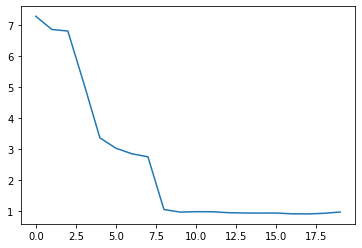

In [140]:
# now we plot the MSE vs the rank
print ("Note that the minimum error is achieved by having r = p which will be the same as OLS or Linear Regression.")

plt.plot(mse)


__Exercise 4__ (30 pts)

The dataset in the hw1 directory has a Y variable, 7 predictor variables (X1 - X7).  Using sklearn and the class that you constructed above, compare ridge regression, OLS, kNN, and SingularValueRegressor.  Compare and tune the methods using appropriate testing procedures.  Comment on the tuning of each parameter in ridge, kNN, and SingularValueRegressor in markdown.  Be sure to standardize the X variables first and decide how to deal with NAs.  

In [1]:
import pandas as pd

In [2]:
data_mat = pd.read_csv('hw1_data.csv')
data_mat.head()

,Y,X1,X2,X3,X4,X5,X6,X7
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0


Some notes for the NAs, you need to replace the NAs somehow to use these methods.  The SimpleImputer will replace the NAs with the mean,median, etc.  You can fit this on the training data and use this to transform for the test set.  We can see that any imputer that is fit only on the training set also can give you that the test error is an unbiased risk estimator.  Let $\hat I$ be the imputer transform and $\hat f$ be any trained predictor.

$$\hat I: R^p \to R^{p}$$
$$\hat f: R^{p} \to R$$

For example,
$(\hat I(x))_j = $ $x_j$ if non-missing and $\hat \mu_j$ if missing 
or you could add a missingness indicator,
$$\hat I_2: R^p \to R^{2p}$$

$(\hat I_2(x))_j = $ $x_j$ if non-missing and $\hat \mu_j$ if missing for $j =1,\ldots,p$

$(\hat I_2(x))_{p+j} = $ $0$ if non-missing and $1$ if missing for $j =1,\ldots,p$

The trained predictor could be linear,
ex. $\hat f(\hat I(x)) = \hat I(x)^\top \hat \beta$

Then we can combine these steps into one predictor,
$\hat g(x) = \hat f (\hat I (x))$.

The test error is still an unbiased risk estimator,
$$\frac{1}{n_t} \sum_{i=n_0+1}^{n_0+n_t} (y_i - \hat g(x_i))^2.$$